In [ ]:
%pip install pandas-ta
%pip install TA-Lib
%pip install ta
%pip install keras-tuner
%pip install nbformat
%pip install fredapi
%pip install yfinance

In [ ]:
import nbformat

path = "Proyecto_TFM_Pro.ipynb"
with open(path, encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.metadata:   
    del nb.metadata["widgets"]

with open("Proyecto_TFM_Pro_clean.ipynb", "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

In [121]:
import yfinance as yf
from fredapi import Fred

# Base
import os
import math
import itertools
import numpy as np
import pandas as pd
import pandas_ta as ta
import ta

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Prétraitement
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Deep Learning - LSTM
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Add, Layer, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential


# ARIMA
#import pmdarima as pm

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics



# Séries temporelles statistiques
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# NLP / Sentiment
#from textblob import TextBlob

# Scraping Reddit
#from psaw import PushshiftAPI

# Utilitaire
#from tqdm.auto import tqdm
#from scipy.stats import kendalltau


# Loading and Preparing Data

In [75]:
gold = yf.download("GC=F", start="2016-01-01", end="2025-05-23")
gold.head()

C:\Users\Sabrine\AppData\Local\Temp\ipykernel_26604\4056894057.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download("GC=F", start="2016-01-01", end="2025-05-23")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


In [76]:
sp500 = yf.download("^GSPC", start="2016-01-01", end="2025-05-23")
sp500.head()

C:\Users\Sabrine\AppData\Local\Temp\ipykernel_26604\4154385743.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2016-01-01", end="2025-05-23")
[*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2016-01-04,2012.660034,2038.199951,1989.680054,2038.199951,4304880000
2016-01-05,2016.709961,2021.939941,2004.170044,2013.780029,3706620000
2016-01-06,1990.260010,2011.709961,1979.050049,2011.709961,4336660000
2016-01-07,1943.089966,1985.319946,1938.829956,1985.319946,5076590000
2016-01-08,1922.030029,1960.400024,1918.459961,1945.969971,4664940000


In [77]:
btc = yf.download("BTC-USD", start="2016-01-01", end="2025-05-23")
btc.head()

C:\Users\Sabrine\AppData\Local\Temp\ipykernel_26604\1576756654.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2016-01-01", end="2025-05-23")
[*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600


In [78]:
fred = Fred(api_key='ee69758895f63b2609f44977c352bfd1')

interest = fred.get_series('FEDFUNDS')
inflation = fred.get_series('CPIAUCSL')

In [79]:
interest_df = interest.to_frame(name="interest_rate")
interest_df.index.name = "date"
interest_df = interest_df.reset_index()

inflation_df = inflation.to_frame(name="inflation_us")
inflation_df.index.name = "date"
inflation_df = inflation_df.reset_index()

In [80]:
interest_df = interest_df[(interest_df["date"] >= "2016-01-01") & (interest_df["date"] <= "2025-05-23")]
inflation_df = inflation_df[(inflation_df["date"] >= "2016-01-01") & (inflation_df["date"] <= "2025-05-23")]


In [81]:
interest_df.head(150)

,date,interest_rate
738,2016-01-01,0.34
739,2016-02-01,0.38
740,2016-03-01,0.36
741,2016-04-01,0.37
742,2016-05-01,0.37
...,...,...
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33
849,2025-04-01,4.33


In [82]:
inflation_df.head(112)

,date,inflation_us
828,2016-01-01,237.652
829,2016-02-01,237.336
830,2016-03-01,238.080
831,2016-04-01,238.992
832,2016-05-01,239.557
...,...,...
935,2024-12-01,317.603
936,2025-01-01,319.086
937,2025-02-01,319.775
938,2025-03-01,319.615


In [83]:
csv_filename = 'fear_greed_index.csv'
FGI_df = pd.read_csv(csv_filename)
FGI_df = FGI_df.rename(columns={"timestamp": "date"})

FGI_df.head(3000)


,date,fear_greed_score
0,2018-02-01,30
1,2018-02-02,15
2,2018-02-03,40
3,2018-02-04,24
4,2018-02-05,11
...,...,...
2655,2025-05-14,73
2656,2025-05-15,70
2657,2025-05-16,71
2658,2025-05-17,74


In [84]:
# Reset the index so 'Date' becomes a column
gold = gold.reset_index()

# Flatten the MultiIndex columns
gold.columns = gold.columns.get_level_values(-0)

# Rename columns with prefix "gold"
gold = gold.rename(columns={
    "Date": "date",
    "Close": "gold_close",
    "Open": "gold_open",
    "High": "gold_high",
    "Low": "gold_low",
    "Volume": "gold_volume"
})

gold.columns.name = None
gold

,date,gold_close,gold_high,gold_low,gold_open,gold_volume
0,2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
1,2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2,2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
3,2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
4,2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98
...,...,...,...,...,...,...
2354,2025-05-16,3182.000000,3228.100098,3173.899902,3227.699951,199
2355,2025-05-19,3228.899902,3241.000000,3228.300049,3234.399902,266
2356,2025-05-20,3280.300049,3293.199951,3207.500000,3219.000000,356
2357,2025-05-21,3309.300049,3317.500000,3290.199951,3293.399902,979


In [85]:
sp500 = sp500.reset_index()

sp500.columns = sp500.columns.get_level_values(0)

sp500 = sp500.rename(columns={
    "Date": "date",
    "Close": "sp500_close",
    "Open": "sp500_open",
    "High": "sp500_high",
    "Low": "sp500_low",
    "Volume": "sp500_volume"
})
sp500.columns.name = None
sp500


,date,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume
0,2016-01-04,2012.660034,2038.199951,1989.680054,2038.199951,4304880000
1,2016-01-05,2016.709961,2021.939941,2004.170044,2013.780029,3706620000
2,2016-01-06,1990.260010,2011.709961,1979.050049,2011.709961,4336660000
3,2016-01-07,1943.089966,1985.319946,1938.829956,1985.319946,5076590000
4,2016-01-08,1922.030029,1960.400024,1918.459961,1945.969971,4664940000
...,...,...,...,...,...,...
2356,2025-05-16,5958.379883,5958.620117,5907.359863,5929.089844,4850850000
2357,2025-05-19,5963.600098,5968.609863,5895.689941,5902.879883,4144010000
2358,2025-05-20,5940.459961,5953.060059,5909.259766,5944.660156,4416850000
2359,2025-05-21,5844.609863,5938.370117,5830.910156,5910.180176,5254250000


In [86]:
btc = btc.reset_index()
btc.columns = btc.columns.get_level_values(0)
btc = btc.rename(columns={
    "Date": "date",
    "Close": "btc_close",
    "Open": "btc_open",
    "High": "btc_high",
    "Low": "btc_low",
    "Volume": "btc_volume"
})
btc.columns.name = None
btc



,date,btc_close,btc_high,btc_low,btc_open,btc_volume
0,2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900
1,2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600
2,2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800
3,2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500
4,2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600
...,...,...,...,...,...,...
3425,2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058
3426,2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647
3427,2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122
3428,2025-05-21,109678.078125,110724.460938,106127.234375,106791.312500,78086364051


In [87]:
# Merge everything
merged = btc.merge(sp500[["date", "sp500_close"]], on="date", how="left")
merged = merged.merge(gold[["date", "gold_close"]], on="date", how="left")
merged

,date,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close
0,2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN
1,2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN
2,2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN
3,2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976
4,2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024
...,...,...,...,...,...,...,...,...
3425,2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN
3426,2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902
3427,2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049
3428,2025-05-21,109678.078125,110724.460938,106127.234375,106791.312500,78086364051,5844.609863,3309.300049


In [88]:
# Convert FGI_df['date'] to datetime
FGI_df['date'] = pd.to_datetime(FGI_df['date'])

#  convert merged['date'] as well
merged['date'] = pd.to_datetime(merged['date'])

In [89]:
merged = merged.merge(interest_df, on="date", how="left")
merged = merged.merge(inflation_df, on="date", how="left")
merged = merged.merge(FGI_df, on="date", how="left")
merged

,date,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
0,2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN,0.34,237.652,NaN
1,2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,NaN,NaN,NaN
4,2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3425,2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN,NaN,NaN,74.0
3426,2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,NaN,NaN,NaN
3427,2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,NaN,NaN,NaN
3428,2025-05-21,109678.078125,110724.460938,106127.234375,106791.312500,78086364051,5844.609863,3309.300049,NaN,NaN,NaN


In [90]:
# Drop duplicates
merged = merged.drop(columns=["interest_rate_y", "inflation_us_y"])

# Rename the remaining ones
merged = merged.rename(columns={
    "interest_rate_x": "interest_rate",
    "inflation_us_x": "inflation_us"
})


KeyError: "['interest_rate_y', 'inflation_us_y'] not found in axis"

In [91]:
#observe the different feature type present in the data
print("=============================================")
print("Data types of the columns in the data frame:",merged.dtypes)
print("=============================================")
print("Shape of the data frame:", merged.shape)
print("=============================================")
print("Information about the data frame:", merged.info())

Data types of the columns in the data frame: date                datetime64[ns]
btc_close                  float64
btc_high                   float64
btc_low                    float64
btc_open                   float64
btc_volume                   int64
sp500_close                float64
gold_close                 float64
interest_rate              float64
inflation_us               float64
fear_greed_score           float64
dtype: object
Shape of the data frame: (3430, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              3430 non-null   datetime64[ns]
 1   btc_close         3430 non-null   float64       
 2   btc_high          3430 non-null   float64       
 3   btc_low           3430 non-null   float64       
 4   btc_open          3430 non-null   float64       
 5   btc_volume        3430 non-nul

In [92]:
merged.set_index('date', inplace=True)
merged

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
date,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN,0.34,237.652,NaN
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN,NaN,NaN,NaN
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,NaN,NaN,NaN
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN,NaN,NaN,74.0
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,NaN,NaN,NaN
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,NaN,NaN,NaN


In [93]:
assert  merged.isnull().values.any(), "Data contains NaNs"

In [94]:
nan_rows_fetched_data = merged[merged.isnull().any(axis=1)]
nan_rows_fetched_data

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
date,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN,0.34,237.652,NaN
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN,NaN,NaN,NaN
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,NaN,NaN,NaN
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN,NaN,NaN,74.0
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,NaN,NaN,NaN
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,NaN,NaN,NaN


In [95]:
merged = merged.sort_values("date")

In [96]:
# Interpolation linéaire sur les colonnes numériques
merged_interpolated = merged.interpolate(method='linear', limit_direction='both')

In [97]:
print("Valeurs manquantes après interpolation :")
print(merged_interpolated.isnull().sum())

Valeurs manquantes après interpolation :
btc_close           0
btc_high            0
btc_low             0
btc_open            0
btc_volume          0
sp500_close         0
gold_close          0
interest_rate       0
inflation_us        0
fear_greed_score    0
dtype: int64


In [98]:
df = merged_interpolated
df

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
date,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,2012.660034,1075.099976,0.340000,237.652000,30.0
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,2012.660034,1075.099976,0.341290,237.641806,30.0
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,2012.660034,1075.099976,0.342581,237.631613,30.0
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,0.343871,237.621419,30.0
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,0.345161,237.611226,30.0
...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,5961.860026,3213.266602,4.330000,320.580000,74.0
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,4.330000,320.580000,74.0
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,4.330000,320.580000,74.0


In [99]:
df['btc_close'] = pd.to_numeric(df['btc_close'], errors='coerce')
df.dropna(subset=['btc_close'], inplace=True)

In [100]:
# 1) Prev_Close : on décale puis on remplace la première valeur
df['Prev_Close'] = df['btc_close'].shift(1)
df['Prev_Close'].iloc[0] = df['btc_close'].iloc[0] 

# 2) Log_Return : calcul et remplacement des NaN
df['Log_Return'] = np.log(df['btc_close'] / df['Prev_Close'])
df['Log_Return'].fillna(0, inplace=True)

# 3) Moyennes mobiles avec min_periods=1
df['MA_3'] = df['btc_close'].rolling(window=3, min_periods=1).mean()
df['MA_7'] = df['btc_close'].rolling(window=7, min_periods=1).mean()

C:\Users\Sabrine\AppData\Local\Temp\ipykernel_26604\1392871815.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Prev_Close'].iloc[0] = df['btc_close'].iloc[0]
C:\Users\Sabrine\AppData\Local\Temp\ipykernel_26604\1392871815.py:3: Settin

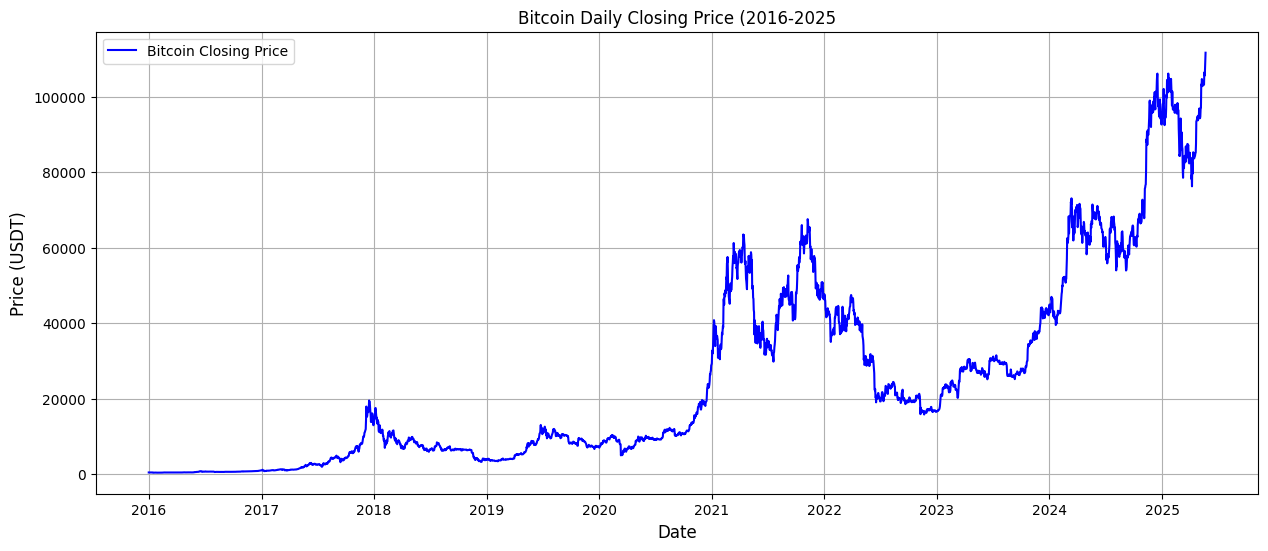

In [101]:
# Plot theb Bitcoin  prices graph
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['btc_close'], label='Bitcoin Closing Price', color='blue')
plt.title('Bitcoin Daily Closing Price (2016-2025')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USDT)', fontsize=12)
plt.legend()
plt.grid(True)


# Show the plt
plt.show()

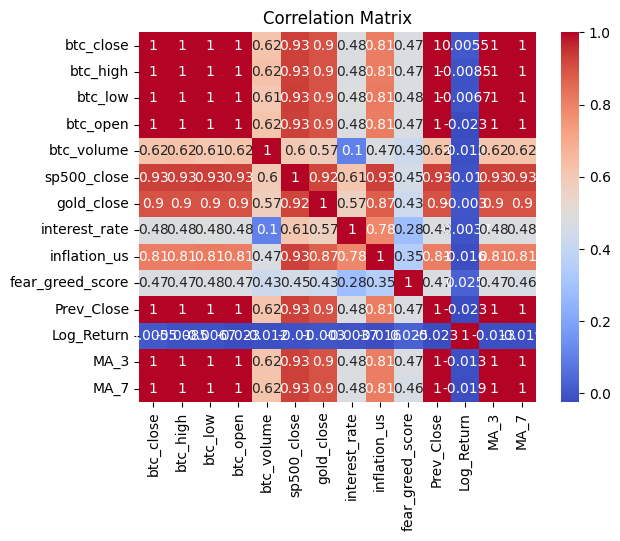

In [102]:

correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

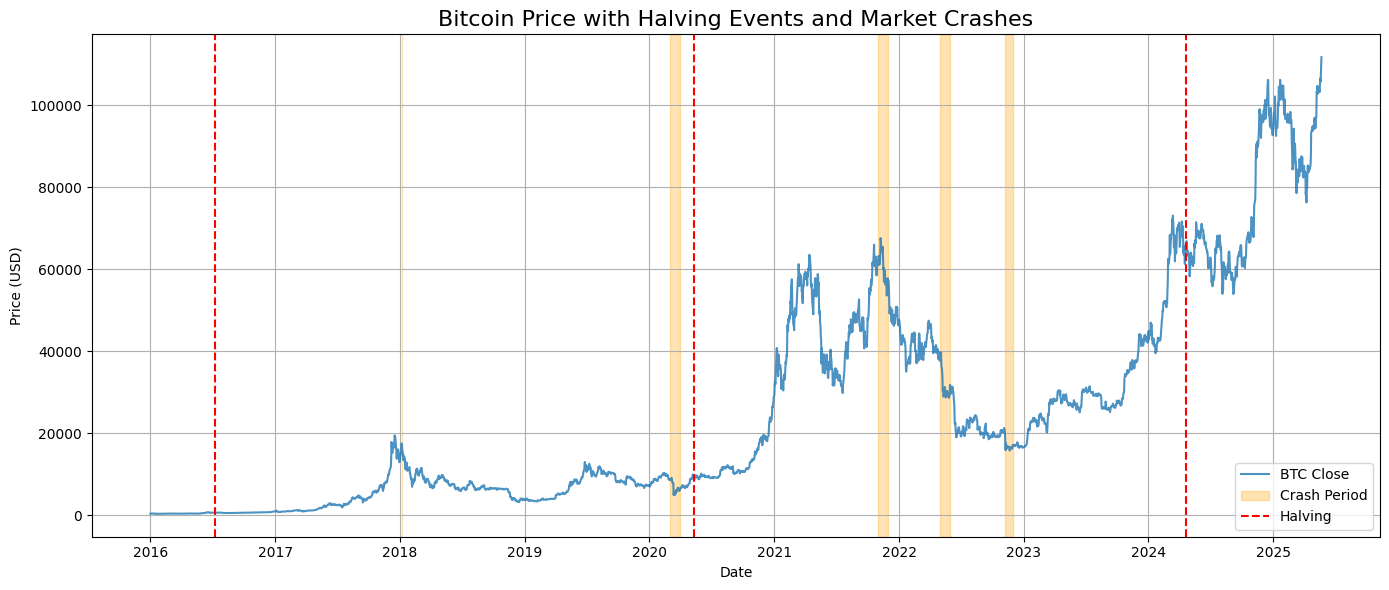

In [103]:

# Nettoyage de l'index (dates sans heures ni timezone)
df.index = pd.to_datetime(df.index).normalize()

# Définition des événements de halving et crash (sans timezone)
halving_dates = [
    pd.Timestamp("2016-07-09"),
    pd.Timestamp("2020-05-11"),
    pd.Timestamp("2024-04-20"),
]

crash_periods = [
    (pd.Timestamp("2018-01-06"), pd.Timestamp("2018-01-06")),
    (pd.Timestamp("2020-03-01"), pd.Timestamp("2020-03-31")),
    (pd.Timestamp("2021-11-01"), pd.Timestamp("2021-11-30")),
    (pd.Timestamp("2022-05-01"), pd.Timestamp("2022-05-31")),
    (pd.Timestamp("2022-11-08"), pd.Timestamp("2022-11-30")),
]

# Flags pour événements
df["halving_flag"] = df.index.isin(halving_dates)
df["crash_flag"] = False
for start, end in crash_periods:
    df.loc[start:end, "crash_flag"] = True

# Attribution de régimes
df["regime"] = "normal"
df.loc[df["halving_flag"], "regime"] = "halving"
df.loc[df["crash_flag"], "regime"] = "crash"

# final plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["btc_close"], label="BTC Close", alpha=0.8)

# Crashes (orange shaded areas)
for start, end in crash_periods:
    plt.axvspan(start, end, color="orange", alpha=0.3, label="Crash Period" if start == crash_periods[0][0] else "")

# Halvings (red dashed lines)
for date in halving_dates:
    plt.axvline(date, color="red", linestyle="--", linewidth=1.5, label="Halving" if date == halving_dates[0] else "")

plt.title("Bitcoin Price with Halving Events and Market Crashes", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [104]:
df['halving_flag'] = df['halving_flag'].astype(int)
df['crash_flag']   = df['crash_flag'].astype(int)

In [105]:
df

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score,Prev_Close,Log_Return,MA_3,MA_7,halving_flag,crash_flag,regime
date,,,,,,,,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,2012.660034,1075.099976,0.340000,237.652000,30.0,434.334015,0.000000,434.334015,434.334015,0,0,normal
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,2012.660034,1075.099976,0.341290,237.641806,30.0,434.334015,-0.002065,433.886002,433.886002,0,0,normal
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,2012.660034,1075.099976,0.342581,237.631613,30.0,433.437988,-0.007938,432.594330,432.594330,0,0,normal
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,0.343871,237.621419,30.0,430.010986,0.007137,432.179993,432.718498,0,0,normal
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,0.345161,237.611226,30.0,433.091003,-0.002615,431.687327,432.566797,0,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,5961.860026,3213.266602,4.330000,320.580000,74.0,103191.085938,0.031055,104375.460938,103913.314732,0,0,normal
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,4.330000,320.580000,74.0,106446.007812,-0.007921,105081.091146,104312.347098,0,0,normal
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,4.330000,320.580000,74.0,105606.179688,0.011158,106281.091146,104686.814732,0,0,normal


In [106]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df["btc_close"].dropna())

print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

if adf_result[1] < 0.05:
    print("Série stationnaire")
else:
    print("Série non stationnaire")

ADF Test Statistic: 0.35846961601803046
p-value: 0.9798736287973067
Critical Value (1%): -3.4322742112538958
Critical Value (5%): -2.8623902053483077
Critical Value (10%): -2.567222580397986
Série non stationnaire


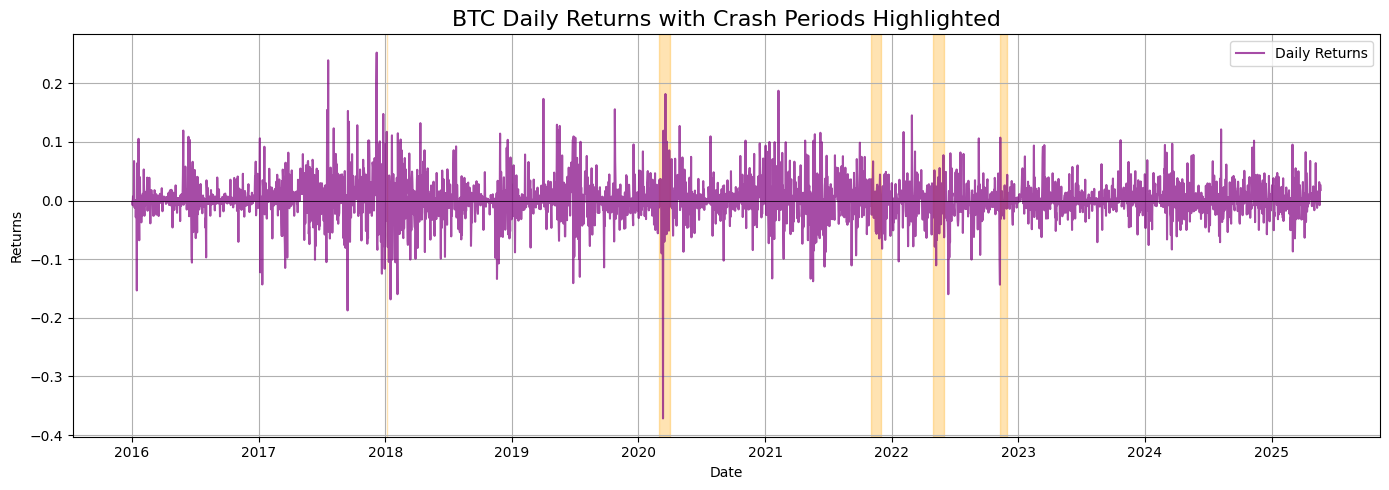

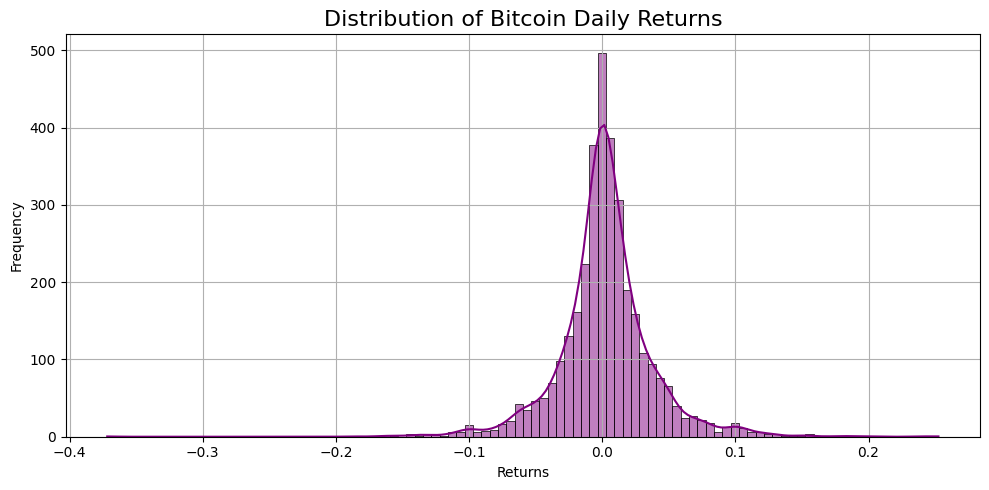

In [107]:
# Returns volatility
df["returns"] = df["btc_close"].pct_change()

plt.figure(figsize=(14, 5))
plt.plot(df.index, df["returns"], color="purple", alpha=0.7, label="Daily Returns")
plt.axhline(0, color="black", linewidth=0.5)

for start, end in crash_periods:
    plt.axvspan(start, end, color="orange", alpha=0.3)

plt.title("BTC Daily Returns with Crash Periods Highlighted", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["returns"].dropna(), kde=True, bins=100, color="purple")
plt.title("Distribution of Bitcoin Daily Returns", fontsize=16)
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

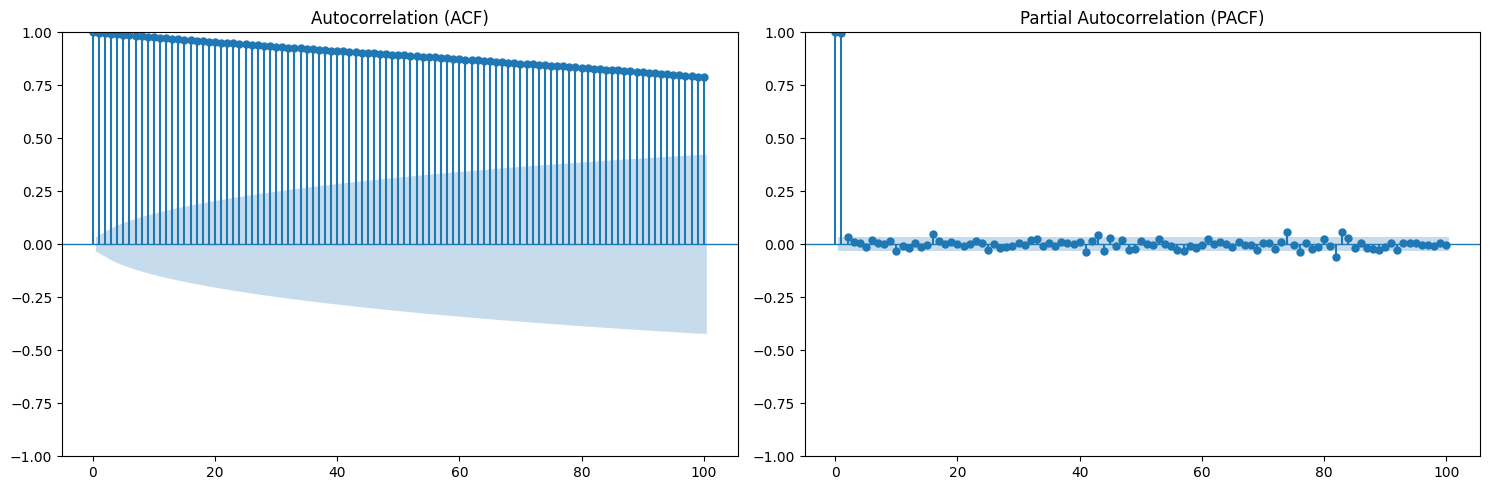

In [108]:
# Autocorrelation and Partial Autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df["btc_close"].dropna(), ax=axes[0], lags=100, linewidth=1)
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(df["btc_close"].dropna(), ax=axes[1], lags=100, method="ywm", linewidth=1)
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

In [109]:
# How BTC moves around halving/crash events.
print(df.groupby("regime")["btc_close"].agg(["mean","std","count"]))

                 mean           std  count
regime                                    
crash    29442.007455  20818.013623    116
halving  24749.065776  35079.504594      3
normal   25141.280230  26242.796861   3311


In [110]:
df['day_of_week'] = df.index.dayofweek
df['month_of_year'] = df.index.month
df['week_of_year'] = df.index.isocalendar().week

In [111]:
# Appliquez-la à votre DataFrame df
df.ta.rsi(length=14, append=True)
df.ta.macd(fast=12, slow=26, signal=9, append=True)
df.ta.bbands(length=20, std=2, append=True)

[X] Ooops!!! It's True, the series 'close' was not found in btc_close, btc_high, btc_low, btc_open, btc_volume, sp500_close, gold_close, interest_rate, inflation_us, fear_greed_score, Prev_Close, Log_Return, MA_3, MA_7, halving_flag, crash_flag, regime, returns, day_of_week, month_of_year, week_of_year
[X] Ooops!!! It's True, the series 'close' was not found in btc_close, btc_high, btc_low, btc_open, btc_volume, sp500_close, gold_close, interest_rate, inflation_us, fear_greed_score, Prev_Close, Log_Return, MA_3, MA_7, halving_flag, crash_flag, regime, returns, day_of_week, month_of_year, week_of_year
[X] Ooops!!! It's True, the series 'close' was not found in btc_close, btc_high, btc_low, btc_open, btc_volume, sp500_close, gold_close, interest_rate, inflation_us, fear_greed_score, Prev_Close, Log_Return, MA_3, MA_7, halving_flag, crash_flag, regime, returns, day_of_week, month_of_year, week_of_year


,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score,...,Log_Return,MA_3,MA_7,halving_flag,crash_flag,regime,returns,day_of_week,month_of_year,week_of_year
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,2012.660034,1075.099976,0.340000,237.652000,30.0,...,0.000000,434.334015,434.334015,0,0,normal,NaN,4,1,53
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,2012.660034,1075.099976,0.341290,237.641806,30.0,...,-0.002065,433.886002,433.886002,0,0,normal,-0.002063,5,1,53
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,2012.660034,1075.099976,0.342581,237.631613,30.0,...,-0.007938,432.594330,432.594330,0,0,normal,-0.007907,6,1,53
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,0.343871,237.621419,30.0,...,0.007137,432.179993,432.718498,0,0,normal,0.007163,0,1,1
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,0.345161,237.611226,30.0,...,-0.002615,431.687327,432.566797,0,0,normal,-0.002611,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,5961.860026,3213.266602,4.330000,320.580000,74.0,...,0.031055,104375.460938,103913.314732,0,0,normal,0.031543,6,5,20
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,4.330000,320.580000,74.0,...,-0.007921,105081.091146,104312.347098,0,0,normal,-0.007890,0,5,21
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,4.330000,320.580000,74.0,...,0.011158,106281.091146,104686.814732,0,0,normal,0.011220,1,5,21


In [112]:
# The 'regime' column contains text values. We'll convert it into numeric columns using one-hot encoding.
print("Encoding the 'regime' column...")

# Step 1: Create dummy columns (one-hot encoding)
# This will create new columns: regime_normal, regime_halving, regime_crash
regime_dummies = pd.get_dummies(df['regime'], prefix='regime', dtype=int)

# Step 2: Concatenate the new dummy columns to the original DataFrame
df = pd.concat([df, regime_dummies], axis=1)

# Step 3: Drop the original 'regime' column (since it contains text)
df = df.drop('regime', axis=1)

# Display the result to verify the new columns are added at the end
print("\nDataFrame after encoding. The new columns are at the end:")
print(df.head())

# Check that all columns are now numeric
print("\nNew data types:")
df.info()

Encoding the 'regime' column...

DataFrame after encoding. The new columns are at the end:
             btc_close    btc_high     btc_low    btc_open  btc_volume  \
date                                                                     
2016-01-01  434.334015  436.246002  427.515015  430.721008    36278900   
2016-01-02  433.437988  436.062012  431.869995  434.622009    30096600   
2016-01-03  430.010986  433.743011  424.705994  433.578003    39633800   
2016-01-04  433.091003  434.516998  429.084015  430.061005    38477500   
2016-01-05  431.959991  434.182007  429.675995  433.069000    34522600   

            sp500_close   gold_close  interest_rate  inflation_us  \
date                                                                
2016-01-01  2012.660034  1075.099976       0.340000    237.652000   
2016-01-02  2012.660034  1075.099976       0.341290    237.641806   
2016-01-03  2012.660034  1075.099976       0.342581    237.631613   
2016-01-04  2012.660034  1075.099976       0.

In [113]:
def add_technical_features(df):
    df['returns'] = df['btc_close'].pct_change()
    df['Log_Return'] = np.log(df['btc_close'] / df['btc_close'].shift(1))
    # Correct way to calculate RSI with ta library
    df['RSI_14'] = ta.momentum.RSIIndicator(close=df['btc_close'], window=14).rsi()
    df['volatility_7'] = df['returns'].rolling(window=7).std()
    df = df.dropna()
    return df

# Load your data into df before calling this function
df = add_technical_features(df)
df

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score,...,crash_flag,returns,day_of_week,month_of_year,week_of_year,regime_crash,regime_halving,regime_normal,RSI_14,volatility_7
date,,,,,,,,,,,,,,,,,,,,,
2016-01-14,430.306000,433.324005,427.845001,432.287994,43945500,1921.839966,1073.900024,0.356774,237.519484,30.0,...,0,-0.004776,3,1,2,0,0,1,41.594215,0.010054
2016-01-15,364.330994,430.255005,364.330994,430.255005,153351008,1880.329956,1091.500000,0.358065,237.509290,30.0,...,0,-0.153321,4,1,2,0,0,1,16.447344,0.055625
2016-01-16,387.536011,390.557007,354.914001,365.072998,120352000,1880.579956,1091.100006,0.359355,237.499097,30.0,...,0,0.063692,5,1,2,0,0,1,32.015818,0.065943
2016-01-17,382.299011,390.964996,380.092010,387.152008,45319600,1880.829956,1090.700012,0.360645,237.488903,30.0,...,0,-0.013514,6,1,2,0,0,1,30.628742,0.065467
2016-01-18,387.167999,388.104004,376.665009,381.733002,54403900,1881.079956,1090.300018,0.361935,237.478710,30.0,...,0,0.012736,0,1,3,0,0,1,33.512867,0.066254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,5961.860026,3213.266602,4.330000,320.580000,74.0,...,0,0.031543,6,5,20,0,0,1,73.291251,0.014739
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,4.330000,320.580000,74.0,...,0,-0.007890,0,5,21,0,0,1,69.806332,0.014016
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,4.330000,320.580000,74.0,...,0,0.011220,1,5,21,0,0,1,71.840748,0.013817


# LSTM + exogenous variables 

In [49]:
# ==== Attention Layer ====
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_att = self.add_weight(name='w_att', shape=(input_shape[-1], 1),
                                     initializer='random_normal', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        score = tf.keras.activations.tanh(tf.keras.backend.dot(inputs, self.w_att))
        attention_weights = tf.keras.activations.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.keras.backend.sum(context_vector, axis=1)
        return context_vector

# ==== LSTMTrainer ====
class LSTMTrainer:
    def __init__(self, df, time_step=90, use_log_return=True):
        self.df = df.copy()
        self.time_step = time_step
        self.use_log_return = use_log_return

        # === Feature Engineering avec pandas_ta ===
        self.df['RSI'] = self.df.ta.rsi(close='btc_close', length=14)
        self.df['Volatility'] = self.df['btc_close'].rolling(window=14).std()
        self.df['EMA_7'] = self.df.ta.ema(close='btc_close', length=7)
        self.df['EMA_21'] = self.df.ta.ema(close='btc_close', length=21)
        bb = self.df.ta.bbands(close='btc_close', length=20)
        self.df['Bollinger_Upper'] = bb['BBU_20_2.0']
        self.df['Bollinger_Lower'] = bb['BBL_20_2.0']
        self.df['MACD'] = self.df.ta.macd(close='btc_close')['MACD_12_26_9']
        self.df['ATR'] = self.df.ta.atr(high='btc_high', low='btc_low', close='btc_close', length=14)
        stoch = self.df.ta.stoch(high='btc_high', low='btc_low', close='btc_close')
        self.df['Stoch_K'] = stoch['STOCHk_14_3_3']
        self.df['Stoch_D'] = stoch['STOCHd_14_3_3']


        # === Returns ou log-returns ===
        if use_log_return:
            self.df['log_return'] = np.log(self.df['btc_close'] / self.df['btc_close'].shift(1))
            target_col = 'log_return'
        else:
            self.df['returns'] = self.df['btc_close'].diff(1)
            target_col = 'returns'

        # Nettoyage
        self.df = self.df.dropna().reset_index(drop=True)

        # === Sélection des features ===
        self.feature_cols = [
            target_col, "btc_close", "btc_volume", "Prev_Close", "Log_Return", "MA_3", "MA_7",
            "sp500_close", "gold_close", "interest_rate", "inflation_us",
            "fear_greed_score", "halving_flag", "crash_flag",
            "day_of_week", "month_of_year", "week_of_year",
            "RSI", "Volatility", "EMA_7", "EMA_21", "MACD",
            "Bollinger_Upper", "Bollinger_Lower", "ATR", "Stoch_K", "Stoch_D"
        ]
        # Ne garder que celles présentes dans le df
        self.feature_cols = [col for col in self.feature_cols if col in self.df.columns]

        self.model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))

    def _create_sequences(self, data):
        dataX, dataY = [], []
        for i in range(len(data) - self.time_step):
            seq_X = data[i:(i + self.time_step), :]
            seq_Y = data[i + self.time_step, 0]
            dataX.append(seq_X)
            dataY.append(seq_Y)
        return np.array(dataX), np.array(dataY)

    def prepare_data(self, training_size=0.8):
        print("--- Préparation des données ---")
        self.target_data = self.df[self.feature_cols]
        self.n_features = len(self.feature_cols)
        data_raw = self.target_data.values
        train_len = int(len(data_raw) * training_size)
        train_raw = data_raw[:train_len]
        test_raw = data_raw[train_len:]
        self.scaler.fit(train_raw)
        self.target_scaler.fit(train_raw[:, 0].reshape(-1, 1))
        train_scaled = self.scaler.transform(train_raw)
        test_scaled = self.scaler.transform(test_raw)
        self.X_train, self.y_train = self._create_sequences(train_scaled)
        self.X_test, self.y_test = self._create_sequences(test_scaled)
        self.y_test_actual_prices = self.df['btc_close'].values[train_len + self.time_step:]
        print(f"Forme de X_train: {self.X_train.shape}, X_test: {self.X_test.shape}")
        return self.X_train, self.y_train, self.X_test, self.y_test

    def build_and_tune_model(self, max_trials=15, epochs=50, project_name='btc_returns_tuning'):
        print("\n--- Optimisation du modèle (tuning architecture) ---")
        def model_builder(hp):
            units_1 = hp.Choice('units_1', [64, 96, 128])
            units_2 = hp.Choice('units_2', [32, 64, 96])
            units_3 = hp.Choice('units_3', [32, 64, 96])
            dropout_1 = hp.Float('dropout_1', 0.2, 0.6, step=0.1)
            dropout_2 = hp.Float('dropout_2', 0.2, 0.6, step=0.1)
            dropout_3 = hp.Float('dropout_3', 0.2, 0.6, step=0.1)
            l2_reg = hp.Choice('l2_reg', [1e-4, 1e-3, 5e-3])
            learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
            inputs = Input(shape=(self.time_step, self.n_features))
            x1 = Bidirectional(LSTM(units_1, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg)))(inputs)
            x1 = Dropout(dropout_1)(x1)
            x2 = Bidirectional(LSTM(units_2, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg)))(x1)
            x2 = Dropout(dropout_2)(x2)
            x3 = Bidirectional(LSTM(units_3, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg)))(x2)
            x3 = Dropout(dropout_3)(x3)
            x3_proj = TimeDistributed(Dense(x2.shape[-1]))(x3)
            x_skip = Add()([x2, x3_proj])
            x_att = Attention()(x_skip)
            x_dense1 = Dense(64, activation='relu')(x_att)
            x_dense2 = Dense(16, activation='relu')(x_dense1)
            outputs = Dense(1)(x_dense2)
            model = Model(inputs=inputs, outputs=outputs)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
            return model
        tuner = kt.RandomSearch(model_builder, objective='val_loss', max_trials=max_trials,
                               directory='keras_tuner_dir', project_name=project_name)
        tuner.search(self.X_train, self.y_train, epochs=epochs,
                     validation_data=(self.X_test, self.y_test),
                     callbacks=[EarlyStopping(monitor='val_loss', patience=8)])
        print("\n--- Meilleurs hyperparamètres trouvés ---")
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        self.model = tuner.hypermodel.build(best_hps)
        return self.model

    def train_final_model(self, epochs=150, batch_size=32):
        if self.model is None: raise ValueError("Le modèle doit être construit d'abord.")
        print("\n--- Entraînement du modèle final ---")
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6),
            ModelCheckpoint('best_returns_model.h5', monitor='val_loss', save_best_only=True)
        ]
        self.history = self.model.fit(self.X_train, self.y_train,
                                      validation_data=(self.X_test, self.y_test),
                                      epochs=epochs, batch_size=batch_size, callbacks=callbacks)
        self.plot_training_loss()

    def plot_training_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Perte du Modèle (MSE) par Époque')
        plt.xlabel('Époque')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_model(self):
        print("\n--- Évaluation du modèle final ---")
        self.model.load_weights('best_returns_model.h5')
        predicted_returns_scaled = self.model.predict(self.X_test)
        predicted_returns = self.target_scaler.inverse_transform(predicted_returns_scaled).flatten()
        # Reconstruction des prix à partir des returns/log_returns
        last_known_price = self.df['btc_close'].iloc[-len(self.y_test_actual_prices) - 1]
        reconstructed_prices = [last_known_price]
        for ret in predicted_returns:
            if self.use_log_return:
                reconstructed_prices.append(reconstructed_prices[-1] * np.exp(ret))
            else:
                reconstructed_prices.append(reconstructed_prices[-1] + ret)
        reconstructed_prices = np.array(reconstructed_prices[1:])

        # Scores
        rmse = np.sqrt(mean_squared_error(self.y_test_actual_prices, reconstructed_prices))
        mae = mean_absolute_error(self.y_test_actual_prices, reconstructed_prices)
        mape = np.mean(np.abs((self.y_test_actual_prices - reconstructed_prices) / self.y_test_actual_prices)) * 100
        r2 = r2_score(self.y_test_actual_prices, reconstructed_prices)
        print(f" RMSE Test (sur prix) : {rmse:.2f}")
        print(f" MAPE Test (sur prix) : {mape:.2f}%")
        print(f" MAE Test  (sur prix) : {mae:.2f}")
        print(f" R² Test   (sur prix) : {r2:.4f}")

        # Courbe
        plt.figure(figsize=(15, 7))
        test_indices = self.df.index[-len(self.y_test_actual_prices):]
        plt.plot(self.df.index, self.df['btc_close'], label='Prix Réel du BTC', color='blue', alpha=0.7)
        plt.plot(test_indices, reconstructed_prices, label='Prédiction sur le Test (Reconstruit)', color='red', linestyle='--')
        plt.title("Prédiction du Prix du Bitcoin (Modèle Amélioré)")
        plt.xlabel("Date")
        plt.ylabel("Prix du BTC (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()

In [50]:
trainer = LSTMTrainer(df, time_step=90)

In [51]:

X_train, y_train, X_val, y_val = trainer.prepare_data(training_size=0.8)

--- Préparation des données ---
Forme de X_train: (2623, 90, 27), X_test: (589, 90, 27)


In [53]:
try:
    import keras_tuner as kt
except ImportError:
    %pip install -q -U keras-tuner
    import keras_tuner as kt

In [54]:
trainer.build_and_tune_model(max_trials=15, epochs=5)

Trial 15 Complete [00h 03m 59s]
val_loss: 0.040018122643232346

Best val_loss So Far: 0.02180464193224907
Total elapsed time: 01h 48m 45s

--- Meilleurs hyperparamètres trouvés ---


<Functional name=functional_1, built=True>


--- Entraînement du modèle final ---
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0998

82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - loss: 0.0996 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0568

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0567 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0413

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0413 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0323

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0323 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0265

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0265 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0227

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.0227 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0192

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0192 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0169

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0169 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0157

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0157 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0142

82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - loss: 0.0142 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0124

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - loss: 0.0124 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - loss: 0.0116 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 13/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0107

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - loss: 0.0107 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 14/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0106

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.0106 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 15/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0095

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - loss: 0.0095 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 16/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0089

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - loss: 0.0089 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 17/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0077

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - loss: 0.0077 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 18/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0073

82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - loss: 0.0073 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 19/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0070

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 0.0070 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 20/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0070

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - loss: 0.0070 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 21/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0064

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - loss: 0.0064 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 22/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0058

82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - loss: 0.0058 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 23/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0059

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0059 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 24/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0054

82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - loss: 0.0054 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 25/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0056

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.0056 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 26/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - loss: 0.0051 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 27/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0049

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - loss: 0.0049 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 28/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0047

82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - loss: 0.0047 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 29/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0044

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.0044 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 30/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0045

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - loss: 0.0045 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 31/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0046

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 0.0046 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 32/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0043

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - loss: 0.0043 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 33/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0038

82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 263ms/step - loss: 0.0038 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 34/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - loss: 0.0046 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 35/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0039

82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - loss: 0.0039 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 36/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0039 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 37/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0035

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0035 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 38/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0037

82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - loss: 0.0037 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 39/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - loss: 0.0036 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 40/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0039

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0039 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 41/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 264ms/step - loss: 0.0035 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 42/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0036

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - loss: 0.0036 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 43/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 0.0041 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 44/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0037

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0037 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 45/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0034

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - loss: 0.0034 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 46/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - loss: 0.0032 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 47/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - loss: 0.0033 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 48/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0035

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 0.0035 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 49/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - loss: 0.0032 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 50/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.0037 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 51/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - loss: 0.0036 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 52/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0033

82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 264ms/step - loss: 0.0033 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 53/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 263ms/step - loss: 0.0036 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 54/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - loss: 0.0032 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 55/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - loss: 0.0032 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 56/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0030

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - loss: 0.0030 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 57/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0031

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - loss: 0.0031 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 58/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - loss: 0.0033 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 59/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - loss: 0.0031 - val_loss: 0.0019 - learning_rate: 2.0000e-04
Epoch 60/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 0.0030 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 61/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0031 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 62/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - loss: 0.0030 - val_loss: 0.0019 - learning_rate: 2.0000e-04
Epoch 63/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - loss: 0.0029 - val_loss: 0.0017 - learning_rate: 4.0000e-05
Epoch 64/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - loss: 0.0035 - val_loss: 0.0016 - learning_rate: 4.0000e-05
Epoch 65/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - loss: 0.0033 - val_l

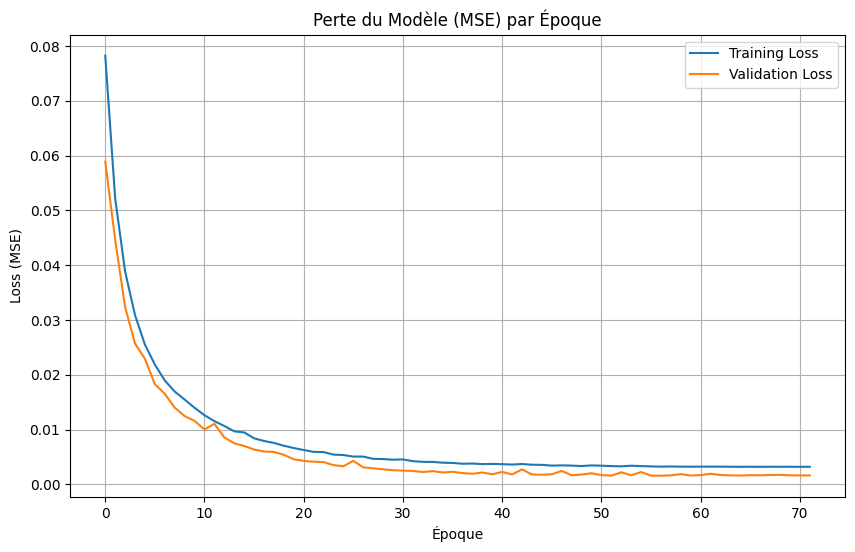


--- Évaluation du modèle final ---
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step
 RMSE Test (sur prix) : 41202.28
 MAPE Test (sur prix) : 43.78%
 MAE Test  (sur prix) : 34034.33
 R² Test   (sur prix) : -2.8803


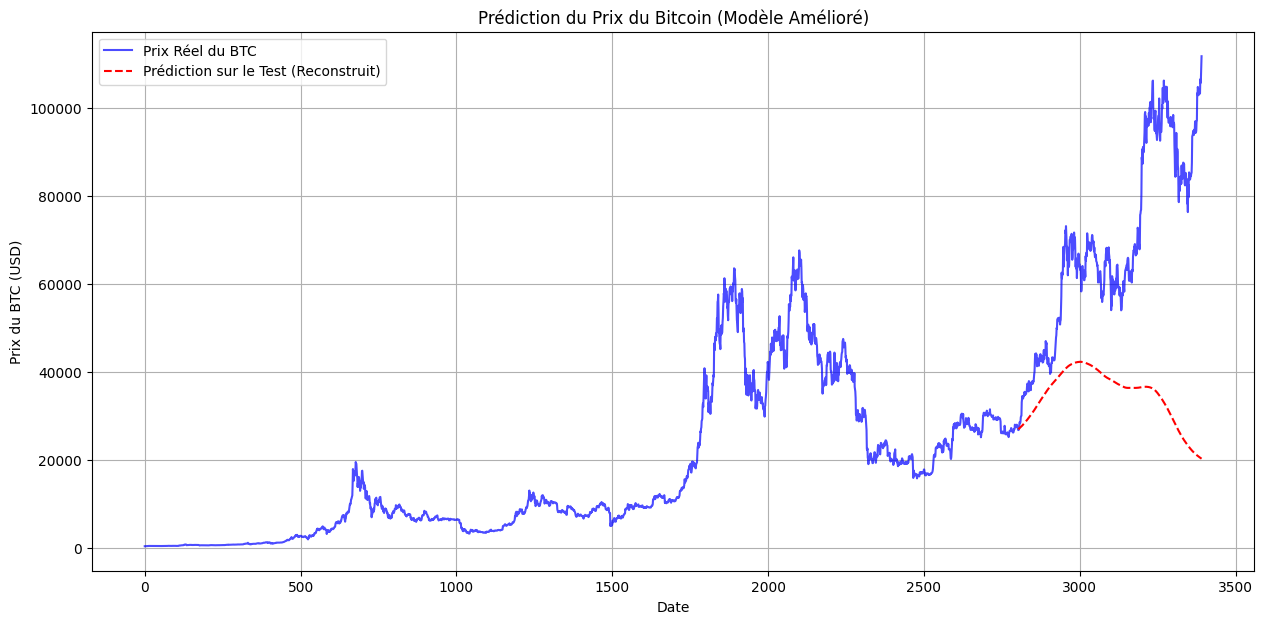

In [55]:
trainer.train_final_model(epochs=100)
trainer.evaluate_model()
